# TODO: Constant dictionary for rename_prod_subcat
# TODO: Create function for dropping rows & resetting index
# TODO: Create distribution by birth year / age?

# Introduction

The goal of this study is to see the emerging markets in the Retail Shop Datasets through cluster analysis.

# 1. Cleaning the Datasets
There are 3 datasets for this study: customers, product categories and transactions. Some columns of the datasets were transformed to lowercase and renamed for easier understanding. Rows with null values were also dropped since they would give no value at all.

At the end of this section, these three are merged into one dataset using SQL syntax enabled by the pandasql library.

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

sns.set(rc={'figure.figsize':(10,10)})

%matplotlib inline

In [2]:
# Load the csv datasets into pandas dataframes
dataset_dir = os.path.join(os.getcwd(), 'dataset')

## 1.1. The Customers Dataset

In [3]:
customer_csv = os.path.join(dataset_dir, 'Customer.csv')
customer_df = pd.read_csv(customer_csv)

In [4]:
customer_df_col_map = {
    'customer_Id': 'customer_id',
    'DOB': 'birth_year',
    'Gender': 'gender'
}
customer_df.rename(columns=customer_df_col_map, inplace=True)

In [5]:
# Check for and drop the rows with null values
customer_df.isna().sum()

customer_id    0
birth_year     0
gender         2
city_code      2
dtype: int64

In [6]:
customer_df.dropna(inplace=True)
customer_df.reset_index(drop=True, inplace=True)

In [7]:
# Transform the former DOB column to Year only
customer_df['birth_year'] = customer_df['birth_year'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').year)

In [8]:
customer_df.head()

,customer_id,birth_year,gender,city_code
0,268408,1970,M,4.0
1,269696,1970,F,8.0
2,268159,1970,F,8.0
3,270181,1970,F,2.0
4,268073,1970,M,1.0


## 1.2. Product Categories Dataset

In [9]:
prodcat_csv = os.path.join(dataset_dir, 'prod_cat_info.csv')
prodcat_df = pd.read_csv(prodcat_csv)

In [10]:
# Rename column prod_subcat to prod_sub_cat for consistency
prodcat_df.rename(columns={'prod_subcat': 'prod_sub_cat'}, inplace=True)

Notice that "prod_cat" column with values "Clothing", "Footwear" and "Bags" all have the same "prod_sub_cat" values. To avoid confusion later on in the clustering, the "prod_sub_cat" values must be unique.

In [11]:
prodcat_df[prodcat_df['prod_cat'].isin(["Clothing", "Footwear", "Bags"])]

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_sub_cat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women
5,2,Footwear,4,Kids
11,4,Bags,1,Mens
12,4,Bags,4,Women


Function rename_prod_sub_cat is created to transform the "prod_sub_cat" values.

In [12]:
def rename_prod_sub_cat(prod_cat_value, old_sub_cat, new_sub_cat):
    # Locate the row that corresponds to parm prod_cat_value and old_sub_cat
    # Replace the prod_sub_cat of that row with the new_sub_cat
    prodcat_df.loc[(prodcat_df['prod_cat'] == prod_cat_value) &
                   (prodcat_df['prod_sub_cat'] == old_sub_cat),
                   'prod_sub_cat'] = new_sub_cat

In [13]:
rename_prod_sub_cat('Clothing', 'Mens', 'clothing_men')
rename_prod_sub_cat('Clothing', 'Women', 'clothing_women')
rename_prod_sub_cat('Clothing', 'Kids', 'clothing_kids')
rename_prod_sub_cat('Footwear', 'Mens', 'footwear_men')
rename_prod_sub_cat('Footwear', 'Women', 'footwear_women')
rename_prod_sub_cat('Footwear', 'Kids', 'footwear_kids')
rename_prod_sub_cat('Bags', 'Mens', 'bags_mens')
rename_prod_sub_cat('Bags', 'Women', 'bags_women')

In [14]:
prodcat_df

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_sub_cat
0,1,Clothing,4,clothing_men
1,1,Clothing,1,clothing_women
2,1,Clothing,3,clothing_kids
3,2,Footwear,1,footwear_men
4,2,Footwear,3,footwear_women
5,2,Footwear,4,footwear_kids
6,3,Electronics,4,Mobiles
7,3,Electronics,5,Computers
8,3,Electronics,8,Personal Appliances
9,3,Electronics,9,Cameras


## 1.3. Transactions Dataset

In [15]:
transact_csv = os.path.join(dataset_dir, 'Transactions.csv')
transact_df = pd.read_csv(transact_csv)

In [16]:
# Set to lowercase these columns of transact_df for easier reference
transact_df_col_map = {
    'cust_id': 'customer_id',
    'prod_subcat_code': 'prod_sub_cat_code',
    'Qty': 'qty',
    'Rate': 'rate',
    'Tax': 'tax',
    'Store_type': 'store_type',
    'tran_date': 'transact_date'
}
transact_df.rename(columns=transact_df_col_map, inplace=True)

There are some transactions where the "qty" columns is less than 1. These can be interpreted as returns or refunds. However, since this study aims to know the emerging markets, these refund rows will be dropped. 

In [17]:
transact_df[transact_df['qty'] < 1].head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [18]:
# Remove the rows where qty is less than 1
rows_to_drop = transact_df[transact_df['qty'] < 1].index
transact_df.drop(rows_to_drop, axis=0, inplace=True)
transact_df.reset_index(drop=True, inplace=True)

Convert "transact_date" to a datetime object. This column has a mix of dates formatted in DD-MM-YYYY and DD/MM/YYYY, so pandas.to_datetime with dayfirst=True param is used

In [19]:
transact_df['transact_date'] = pd.to_datetime(transact_df['transact_date'], dayfirst=True)

Create new columns transact_year and transact_month that are derived from transact_date.

In [20]:
transact_df['transact_year'] = transact_df['transact_date'].dt.year
transact_df['transact_month'] = transact_df['transact_date'].dt.month

In [21]:
transact_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month
0,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,2014,2
1,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,2014,2
2,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2014,2
3,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,2014,2
4,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,2014,2


## 1.4. Merging the Datasets
The library pandasql is used to join the three datasets together using SQL. This is more precise and easier to read, because the SQL Joins allow more control than pandas.

In [22]:
# Use pandasql to easily merge the three datasets together
from pandasql import sqldf

In [23]:
merged_df = lambda query: sqldf(query, globals())
query = """
    SELECT
        t.*,
        c.birth_year,
        c.gender,
        c.city_code,
        p.prod_cat,
        p.prod_sub_cat
    FROM transact_df t
    INNER JOIN customer_df c
        on c.customer_id = t.customer_id
    INNER JOIN prodcat_df p
        ON p.prod_cat_code = t.prod_cat_code
        AND p.prod_sub_cat_code = t.prod_sub_cat_code
"""
merged_df = merged_df(query)

Add new column 'age_at_purchase'

In [24]:
# Add column of age at time of purchase
merged_df['age_at_purchase'] = merged_df['transact_year'] - merged_df['birth_year']

In [25]:
merged_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
0,29258453508,270384,2014-02-20 00:00:00.000000,5,3,5,1497,785.925,8270.925,e-Shop,2014,2,1973,F,8.0,Electronics,Computers,41
1,25455265351,267750,2014-02-20 00:00:00.000000,12,6,3,1360,428.400,4508.400,e-Shop,2014,2,1986,M,1.0,Home and kitchen,Tools,28
2,1571002198,275023,2014-02-20 00:00:00.000000,6,5,4,587,246.540,2594.540,e-Shop,2014,2,1971,M,6.0,Books,DIY,43
3,36554696014,269345,2014-02-20 00:00:00.000000,3,5,3,1253,394.695,4153.695,e-Shop,2014,2,1970,F,10.0,Books,Comics,44
4,56814940239,268799,2014-02-20 00:00:00.000000,7,5,5,368,193.200,2033.200,e-Shop,2014,2,1979,M,9.0,Books,Fiction,35


# 2. Exploring the Data
The goal is to find out which emerging market to look out for. As I narrowed the criteria, I trimmed the merged dataset until I got the ideal dataset for clustering. Aside from having a defined scope, this section also helped me run cluster analysis in R successfully with the hardware specifications of my machine.

## 2.1 Exploring the Merged Dataset

The merged_df has 19,905 rows. This needs to be narrowed down as mentioned above.

In [26]:
merged_df.shape

(20860, 18)

As the 2014 transactions are up to Feburary only, remove all 2014 transactions from the dataframe.

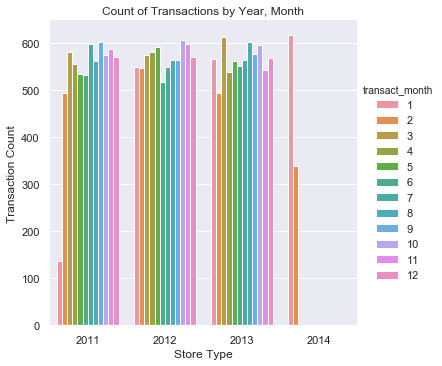

In [27]:
fig = sns.catplot(x='transact_year', kind='count', hue='transact_month' ,data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count", title="Count of Transactions by Year, Month");

In [28]:
rows_to_drop = merged_df[merged_df['transact_year'] == 2014].index
merged_df.drop(rows_to_drop, axis=0, inplace=True)
merged_df.reset_index(drop=True,inplace=True)

Majority of the transactions come from the 'e-Shop'. The number of rows to analyze is significant enough to focus only on the e-Shop.

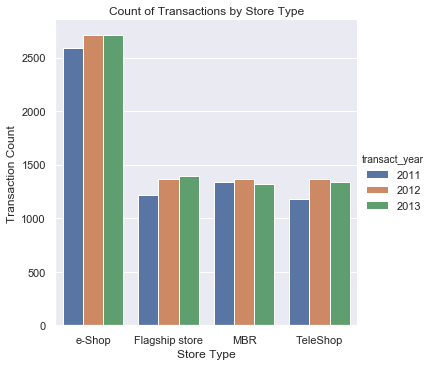

In [29]:
fig = sns.catplot(x='store_type', kind='count', hue='transact_year', data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count",title="Count of Transactions by Store Type");

In addition, the total sales from the e-Shop is the highest among the store types. 

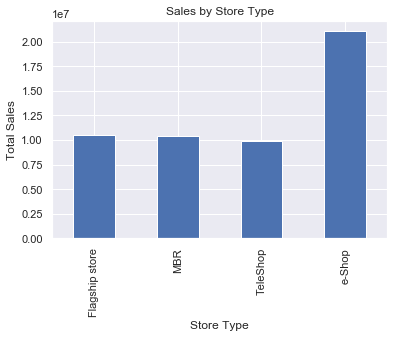

In [30]:
plt = merged_df.groupby('store_type').total_amt.sum().plot(kind='bar');
plt.set_title('Sales by Store Type')
plt.set_ylabel('Total Sales')
plt.set_xlabel('Store Type');

With these, a new dataframe called "eshop_df" is created. It is a copy of the "merged_df", but it will only contain rows where "store_type" is equal to "e_Shop".

In [31]:
eshop_df = merged_df.copy(deep=True)
rows_to_drop = eshop_df[eshop_df['store_type'] != 'e-Shop'].index
eshop_df.drop(rows_to_drop, axis=0, inplace=True)
eshop_df.reset_index(drop=True, inplace=True)
eshop_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
0,58387181112,275068,2013-12-31 00:00:00.000000,8,3,5,792,415.800,4375.800,e-Shop,2013,12,1982,M,2.0,Electronics,Personal Appliances,31
1,26100869804,273836,2013-12-31 00:00:00.000000,9,3,3,843,265.545,2794.545,e-Shop,2013,12,1983,M,10.0,Electronics,Cameras,30
2,4116412179,269788,2013-12-31 00:00:00.000000,10,3,3,984,309.960,3261.960,e-Shop,2013,12,1984,F,1.0,Electronics,Audio and video,29
3,51849180620,273963,2013-12-31 00:00:00.000000,9,3,3,617,194.355,2045.355,e-Shop,2013,12,1971,F,7.0,Electronics,Cameras,42
4,73514951834,269518,2013-12-31 00:00:00.000000,6,5,2,582,122.220,1286.220,e-Shop,2013,12,1980,M,2.0,Books,DIY,33


## 2.2 Exploring the E-Shop Dataset

The chart below shows the Books category having the highest transaction count followed by Electronics, Home and Kitchen.

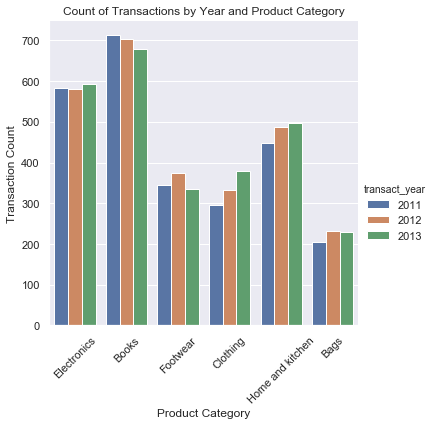

In [32]:
fig = sns.catplot(x='prod_cat', kind='count', hue='transact_year', data=eshop_df)
fig.set(xlabel='Product Category', ylabel="Transaction Count", title="Count of Transactions by Year and Product Category");
fig.set_xticklabels(rotation=45);

The same can be said when checking the store's total sales by year per product category.

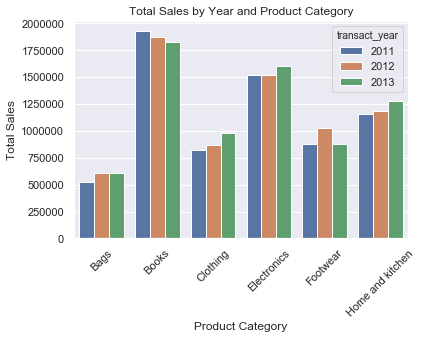

In [33]:
grouped_df = eshop_df.groupby(['prod_cat', 'transact_year']).total_amt.sum().reset_index()
fig = sns.barplot(x='prod_cat', y='total_amt', hue='transact_year', data=grouped_df)
fig.set(xlabel='Product Category', ylabel="Total Sales", title="Total Sales by Year and Product Category")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);

For Bags, Clothing and Home and Kitchen, they are the only product categories whose sales are increasing year by year. While their cumulative sales are lower than that of Books and Electronics, they are gaining traction in the E-Shop.

It is of interest to know the customers who buy from the Bags, Clothing and Home and Kitchen categories. There is a potential for these categories to grow further in sales, and knowing who the right customers are can drive this.

A new dataframe, 'rising_market_df', is created and is derived from the eshop_df.

In [34]:
rising_market_df = eshop_df.copy(deep=True)
rows_to_drop = rising_market_df[~rising_market_df['prod_cat'].isin(['Clothing', 'Home and kitchen', 'Bags'])].index
rising_market_df.drop(rows_to_drop, axis=0, inplace=True)
rising_market_df.reset_index(drop=True)
rising_market_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
6,83963970126,274655,2013-12-31 00:00:00.000000,3,1,5,213,111.825,1176.825,e-Shop,2013,12,1981,M,9.0,Clothing,clothing_kids,32
11,51514545410,270709,2013-12-30 00:00:00.000000,1,1,5,1304,684.600,7204.600,e-Shop,2013,12,1976,M,7.0,Clothing,clothing_women,37
13,83941716509,273771,2013-12-30 00:00:00.000000,4,1,5,725,380.625,4005.625,e-Shop,2013,12,1981,M,2.0,Clothing,clothing_men,32
16,33215457342,272081,2013-12-29 00:00:00.000000,12,6,4,1079,453.180,4769.180,e-Shop,2013,12,1978,F,6.0,Home and kitchen,Tools,35
17,9488888491,267446,2013-12-29 00:00:00.000000,1,4,2,1336,280.560,2952.560,e-Shop,2013,12,1992,M,6.0,Bags,bags_mens,21


## 2.3. Exploring the Rising Markets Dataset

Below is the distribution of birth years of the customers. This is not normally distributed.

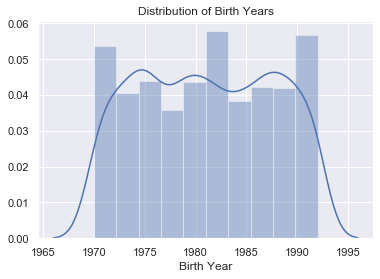

In [35]:
dist = sns.distplot(rising_market_df['birth_year'], bins=10)
dist.set(xlabel='Birth Year', title='Distribution of Birth Years');

All city codes follow the same trend. Home and Kitchen are the most bought category followd by Clothing and Bags. With this, the city_code can be dropped from the clustering.

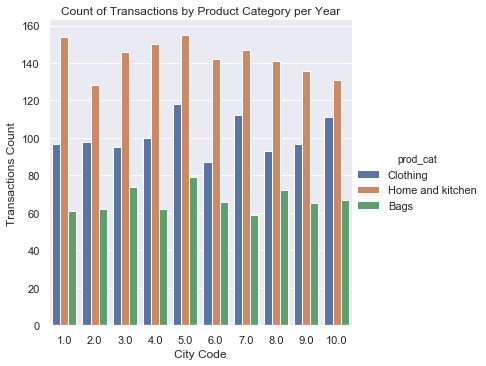

In [36]:
fig = sns.catplot(x='city_code', kind='count', hue='prod_cat', data=rising_market_df)
fig.set(xlabel='City Code', ylabel="Transactions Count", title="Count of Transactions by Product Category per Year");

## 2.4. Dividing the Rising Markets Dataset

The rising_market_df has customers with repeat purchases. They are defined as those who have bought at least twice from the retail store's e-shop.

The code below identified the repeat customers. A new column is created to tag repeat_customers as "yes" or "no" (Y or N).

In [37]:
count_by_customer = rising_market_df.customer_id.value_counts()
repeat_customer_ids = count_by_customer[count_by_customer > 1].index

In [38]:
rising_market_df['repeat_customer'] = None
rising_market_df.loc[rising_market_df['customer_id'].isin(repeat_customer_ids), 'repeat_customer'] = 'Y'
rising_market_df.loc[~rising_market_df['customer_id'].isin(repeat_customer_ids), 'repeat_customer'] = 'N'

There are 1,325 repeat customers and 1,780 new ones.

In [39]:
rising_market_df['repeat_customer'].value_counts()

N    1780
Y    1325
Name: repeat_customer, dtype: int64

Repeat customers have different behaviour compared to first-time customers. To analyze each group, the rising_market_df is divided into two, repeat_df and new_df.

In [40]:
repeat_df = rising_market_df[rising_market_df['repeat_customer'] == 'Y']
new_df = rising_market_df[rising_market_df['repeat_customer'] == 'N']

# 3. Cluster Analysis

## 3.1 Exporting to CSV

Dataframes repeat_df and new_df are exported in CSV format. These will be inputs later on in the cluster in R.

In [41]:
exported_dataset_dir = os.path.join(dataset_dir, 'exported')
if not os.path.exists(exported_dataset_dir):
    os.mkdir(exported_dataset_dir)
    
def export_df_to_csv(df, dir, filename):
    filepath = os.path.join(dir, filename)
    df.to_csv(filepath, index=False)

In [42]:
export_df_to_csv(repeat_df, exported_dataset_dir, 'repeat')
export_df_to_csv(new_df, exported_dataset_dir, 'new')

## 3.2 Mixed Data Clustering in R

### Rationale
R is the programming language used to cluster the two datasets. While python is robust and has many libraries, it simply cannot cluster mixed-data types. After researching, I used a method in R to discover the market segments of this retail store.

### Running the R Scripts
I created 2 R scripts, one for each exported dataset. They are called here from python. Upon execution, these scripts create a CSV file of the clustering results. The CSVs will then be imported in Python.

In [43]:
# subprocess.run(r-1.r)
# subprocess.run(r-2.r)

## 3.4. Viewing the R Notebook and R Scripts

#### R Notebook
This notebook has the steps I took for clustering. It is where I figured out the columns and the number of clusters to use. Please view this at: 

#### R Scripts
With the parameters ready from the R notebook, the scripts below are direct runs of the clustering. These are to speed up the process, since the processing in R notebooks takes a long time.  
Rscript-1 is a direct clustering of the repeat_df.  
Rscript-2 is for the new_df.

## 3.5. Joining the Cluster Results with the Datasets  
In this section, the results from the Rscripts in CSV format are imported aspandas dataframes. They will be joined to the existing repeat_df and new_df using pandasql.